In [254]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display

from IPython.display import Audio
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Conv2D, MaxPooling2D, BatchNormalization, Conv1D, MaxPooling1D, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from scikeras.wrappers import KerasClassifier

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from xgboost import XGBClassifier

In [255]:
np.random.seed(42)
tf.random.set_seed(42)

In [256]:
dataset = pd.read_csv("dataset/features_3_sec.csv")
dataset = dataset.drop(labels="filename", axis=1)

In [257]:
audio = "dataset/genres_original/disco/disco.00025.wav"
data, sr = librosa.load(audio)
Audio(data, rate=sr)

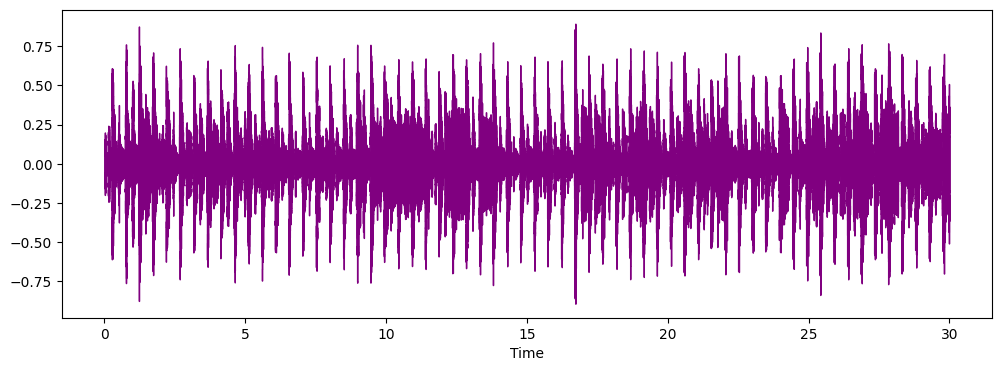

In [258]:
# Plot audio as time series

plt.figure(figsize=(12,4))
librosa.display.waveshow(data, color = "Purple")
plt.show()

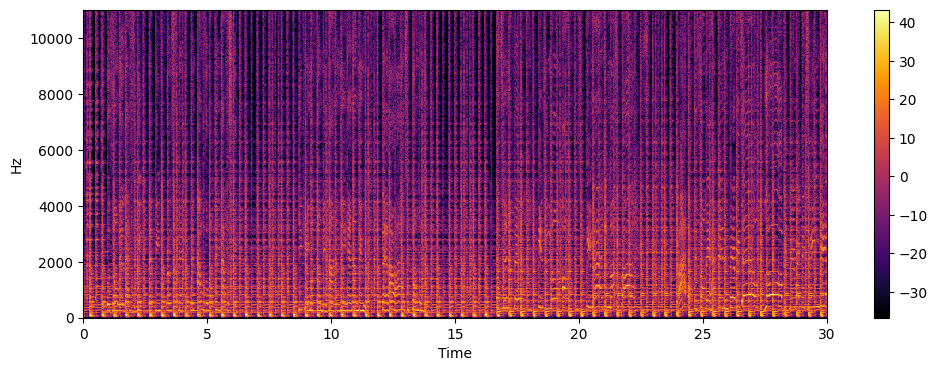

In [259]:
# Convert audio to spectrogram

stft = librosa.stft(data)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(12,4))
librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='hz', cmap="inferno")
plt.colorbar()
plt.show()


In [260]:
# Get classes and encode these to numerical values (0 to 9)

class_list = dataset.iloc[:, -1]
convertor = LabelEncoder()
y = convertor.fit_transform(class_list)

In [261]:
# Get all data except label and standardize features

fit = StandardScaler()
X = fit.fit_transform(np.array(dataset.iloc[:, :-1], dtype = float))
X.shape

(9990, 58)

In [262]:
# Split data into train, validation and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [93]:
# Train simple XGBClassifier

model_xgboost = XGBClassifier(n_estimators=1000)
model_xgboost.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [94]:
# Test XGBClassifier

y_pred_train_xgboost = model_xgboost.predict(X_train)
y_pred_test_xgboost = model_xgboost.predict(X_test)
target_names = sorted(set(y))

print(f'Training accuracy: {accuracy_score(y_train, y_pred_train_xgboost)}')
print(f'Testing accuracy: {accuracy_score(y_test, y_pred_test_xgboost)}')

Training accuracy: 0.9992849992849993
Testing accuracy: 0.9019019019019019


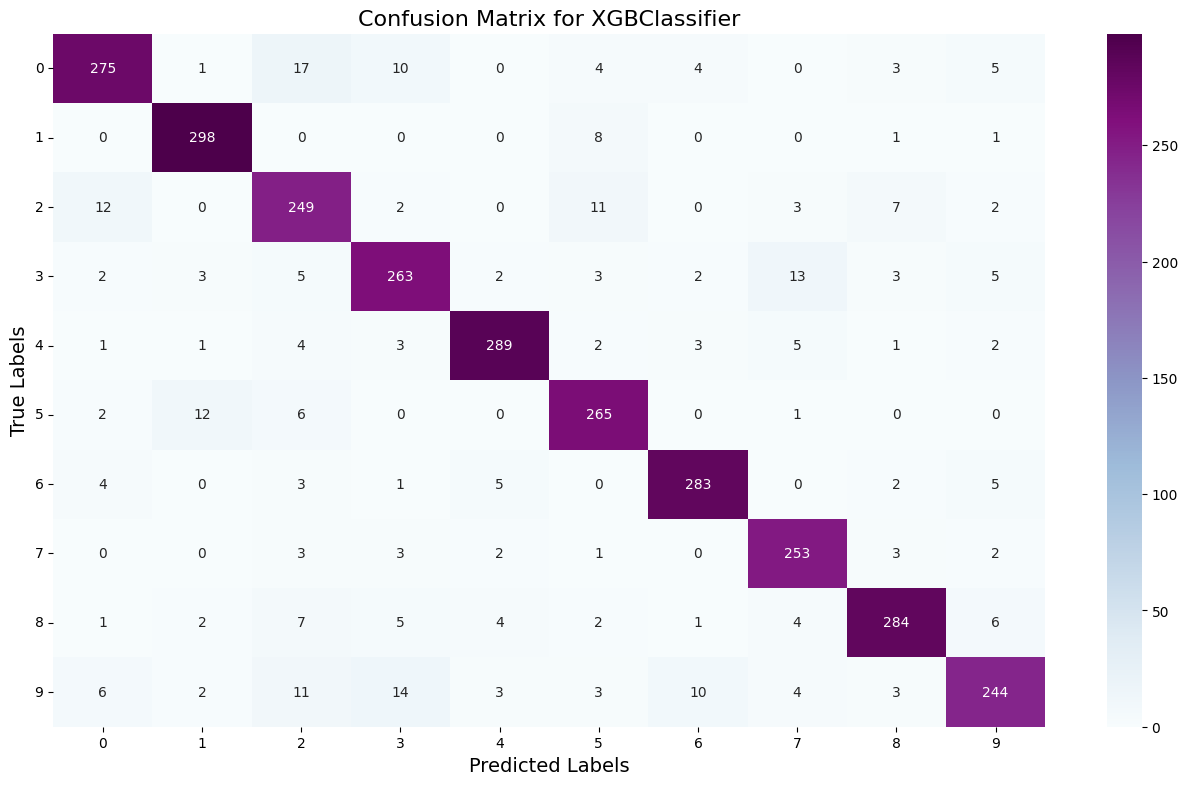

In [95]:
# Confusion Matrix XGBClassifier

con_mat_xgboost = confusion_matrix(y_test, y_pred_test_xgboost)
plt.figure(figsize = (16, 9))
sns.heatmap( con_mat_xgboost, annot=True, fmt="g", cmap="BuPu", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.title("Confusion Matrix for XGBClassifier", fontsize=16)
plt.xticks()
plt.yticks(rotation=0)
plt.show()

In [263]:
# Create function for Feed-Forward Neural Network 

def create_fnn_model(optimizer='adam', dropout_rate=0.2):
    model_fnn = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(512, activation="relu"),
        Dropout(dropout_rate),
        Dense(256, activation="relu"),
        Dropout(dropout_rate),
        Dense(128,activation="relu"),
        Dropout(dropout_rate),
        Dense(64,activation="relu"),
        Dropout(dropout_rate),
        Dense(32,activation="relu"),
        Dropout(dropout_rate),
        Dense(10, activation='softmax')
    ])
    
    model_fnn.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model_fnn


In [269]:
# Setup parameters and randomized search

model_fnn = KerasClassifier(model=create_fnn_model, verbose=0, dropout_rate=[0.2, 0.3, 0.4], optimizer=['adam', 'sgd', 'rmsprop'])

param_grid = {
    "batch_size": [64, 128, 256, 512],
    "epochs": [100, 200, 300],
    "dropout_rate": [0.2, 0.3, 0.4],
    "optimizer": ["adam", "sgd", "rmsprop"]
}

# Chose n = 30, because 40 kept failing near the end because out of memory error (RAM)
random_search_fnn = RandomizedSearchCV(estimator=model_fnn, param_distributions=param_grid, n_iter=30, verbose=2, n_jobs=1, random_state=42)

In [270]:
random_search_result_fnn = random_search_fnn.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


2025-01-07 18:03:37.320000: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_22_0', 768 bytes spill stores, 720 bytes spill loads

2025-01-07 18:03:37.764222: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_36', 24 bytes spill stores, 24 bytes spill loads

2025-01-07 18:03:37.929282: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_22_0', 228 bytes spill stores, 228 bytes spill loads



[CV] END batch_size=256, dropout_rate=0.4, epochs=200, optimizer=rmsprop; total time=  20.3s


[CV] END batch_size=256, dropout_rate=0.4, epochs=200, optimizer=rmsprop; total time=  17.0s


[CV] END batch_size=256, dropout_rate=0.4, epochs=200, optimizer=rmsprop; total time=  17.8s
[CV] END batch_size=256, dropout_rate=0.4, epochs=200, optimizer=rmsprop; total time=  17.2s
[CV] END batch_size=256, dropout_rate=0.4, epochs=200, optimizer=rmsprop; total time=  17.3s


2025-01-07 18:05:13.199867: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_22', 12 bytes spill stores, 12 bytes spill loads

2025-01-07 18:05:13.588760: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_29', 12 bytes spill stores, 12 bytes spill loads

2025-01-07 18:05:13.653640: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_36', 12 bytes spill stores, 12 bytes spill loads



[CV] END batch_size=64, dropout_rate=0.3, epochs=100, optimizer=sgd; total time=  26.0s
[CV] END batch_size=64, dropout_rate=0.3, epochs=100, optimizer=sgd; total time=  24.1s
[CV] END batch_size=64, dropout_rate=0.3, epochs=100, optimizer=sgd; total time=  23.4s


2025-01-07 18:06:26.374816: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_29', 12 bytes spill stores, 12 bytes spill loads

2025-01-07 18:06:26.497449: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_22', 12 bytes spill stores, 12 bytes spill loads

2025-01-07 18:06:26.741086: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_36', 12 bytes spill stores, 12 bytes spill loads



[CV] END batch_size=64, dropout_rate=0.3, epochs=100, optimizer=sgd; total time=  25.6s
[CV] END batch_size=64, dropout_rate=0.3, epochs=100, optimizer=sgd; total time=  25.1s
[CV] END batch_size=64, dropout_rate=0.2, epochs=200, optimizer=sgd; total time=  41.7s
[CV] END batch_size=64, dropout_rate=0.2, epochs=200, optimizer=sgd; total time=  43.2s
[CV] END batch_size=64, dropout_rate=0.2, epochs=200, optimizer=sgd; total time=  43.2s
[CV] END batch_size=64, dropout_rate=0.2, epochs=200, optimizer=sgd; total time=  42.8s
[CV] END batch_size=64, dropout_rate=0.2, epochs=200, optimizer=sgd; total time=  43.4s


2025-01-07 18:10:28.135503: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2326', 56 bytes spill stores, 56 bytes spill loads

2025-01-07 18:10:28.192542: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2326', 2140 bytes spill stores, 2036 bytes spill loads

2025-01-07 18:10:28.204880: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2326', 440 bytes spill stores, 440 bytes spill loads

2025-01-07 18:10:36.630630: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_22_0', 768 bytes spill stores, 720 bytes spill loads

2025-01-07 18:10:36.631083: I external/local_xla/xla

[CV] END batch_size=512, dropout_rate=0.2, epochs=100, optimizer=rmsprop; total time=  13.1s
[CV] END batch_size=512, dropout_rate=0.2, epochs=100, optimizer=rmsprop; total time=   8.3s
[CV] END batch_size=512, dropout_rate=0.2, epochs=100, optimizer=rmsprop; total time=   8.8s


2025-01-07 18:11:06.331453: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_22', 12 bytes spill stores, 12 bytes spill loads

2025-01-07 18:11:06.662466: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_22_0', 756 bytes spill stores, 444 bytes spill loads

2025-01-07 18:11:06.666359: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_29_0', 168 bytes spill stores, 168 bytes spill loads

2025-01-07 18:11:06.785281: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_29', 12 bytes spill stores, 12 bytes spill loads

2025-01-07 18:11:06.787588: I external/local_xla/xla/stream_

[CV] END batch_size=512, dropout_rate=0.2, epochs=100, optimizer=rmsprop; total time=  10.7s
[CV] END batch_size=512, dropout_rate=0.2, epochs=100, optimizer=rmsprop; total time=   8.1s
[CV] END batch_size=256, dropout_rate=0.2, epochs=300, optimizer=rmsprop; total time=  24.2s
[CV] END batch_size=256, dropout_rate=0.2, epochs=300, optimizer=rmsprop; total time=  23.4s
[CV] END batch_size=256, dropout_rate=0.2, epochs=300, optimizer=rmsprop; total time=  23.0s
[CV] END batch_size=256, dropout_rate=0.2, epochs=300, optimizer=rmsprop; total time=  23.5s
[CV] END batch_size=256, dropout_rate=0.2, epochs=300, optimizer=rmsprop; total time=  23.8s
[CV] END batch_size=256, dropout_rate=0.3, epochs=200, optimizer=sgd; total time=  16.8s
[CV] END batch_size=256, dropout_rate=0.3, epochs=200, optimizer=sgd; total time=  17.1s
[CV] END batch_size=256, dropout_rate=0.3, epochs=200, optimizer=sgd; total time=  17.3s
[CV] END batch_size=256, dropout_rate=0.3, epochs=200, optimizer=sgd; total time= 

In [271]:
best_model_fnn = random_search_result_fnn.best_estimator_
y_pred_fnn = best_model_fnn.predict(X_test)
test_accuracy_fnn = accuracy_score(y_test, y_pred_fnn)
print(f"Test Accuracy: {test_accuracy_fnn:.4f}")

2025-01-07 19:12:48.067360: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_22', 12 bytes spill stores, 12 bytes spill loads

2025-01-07 19:12:48.395211: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_22_0', 756 bytes spill stores, 444 bytes spill loads

2025-01-07 19:12:48.452032: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_29', 12 bytes spill stores, 12 bytes spill loads

2025-01-07 19:12:48.735110: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_36', 12 bytes spill stores, 12 bytes spill loads

2025-01-07 19:12:48.808730: I external/local_xla/xla/stream_exec

Test Accuracy: 0.9273


In [272]:
random_search_result_fnn.best_params_

{'optimizer': 'sgd', 'epochs': 300, 'dropout_rate': 0.4, 'batch_size': 256}

In [273]:
keras_model_fnn = best_model_fnn.model_
keras_model_fnn.save("checkpoints/trained_fnn_3_sec_hw.h5", include_optimizer=True)

In [274]:
loaded_model_fnn = load_model("checkpoints/trained_fnn_3_sec_hw.h5")
y_pred_fnn = loaded_model_fnn.predict(X_test)
y_pred_fnn_classes = np.argmax(y_pred_fnn, axis=1)
test_accuracy_fnn = accuracy_score(y_test, y_pred_fnn_classes)
print(f"Test Accuracy: {test_accuracy_fnn:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Test Accuracy: 0.9273


In [252]:
# Expand dimensions for CNN_2d input

height, width = 29, 2
X_train_cnn_2d = X_train.reshape(-1, height, width, 1)
X_test_cnn_2d = X_test.reshape(-1, height, width, 1)  # Add channel dimension
print("X_train_cnn.shape: " + str(X_train_cnn_2d.shape) + " X_test_cnn.shape: " + str(X_test_cnn_2d.shape))

X_train_cnn.shape: (6993, 29, 2, 1) X_test_cnn.shape: (2997, 29, 2, 1)


In [256]:
#Source: https://github.com/crlandsc/Music-Genre-Classification-Using-Convolutional-Neural-Networks/blob/c6d396fc8c9bd7ab888cc4fa14e4f4ce088fceab/code/02_modeling.ipynb (Header: Convolutional Neural Network (With Regularization and Data Augmentation))

def create_cnn_2d_model(optimizer='adam', dropout_rate='0.2'):
    model_cnn_2d = Sequential([
        Input(shape=(29, 2, 1)),
        Conv2D(32, 2, activation="relu"),
        BatchNormalization(),
        MaxPooling2D(2, padding="same"),
        Dropout(dropout_rate),
        Conv2D(64, 1, activation="relu",),
        BatchNormalization(),
        MaxPooling2D(1, padding="same"),
        Dropout(dropout_rate),
        Flatten(),
        Dense(128, activation="softmax"),
        Dropout(dropout_rate),
        Dense(10, activation="softmax")
    ])
    
    model_cnn_2d.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model_cnn_2d

In [257]:
model_cnn = KerasClassifier(model=create_cnn_2d_model, verbose=1, dropout_rate=[0.1, 0.3, 0.5], optimizer=['adam', 'sgd', 'rmsprop'])

param_grid = {
    "batch_size": [64, 128, 256],
    "epochs": [100, 200, 300],
    "dropout_rate": [0.1, 0.3, 0.5],
    "optimizer": ["adam", "sgd", "rmsprop"]
}

early_stopping = EarlyStopping(monitor='val_loss', patience=0) #restore_best_weights=True

random_search_cnn_2d = RandomizedSearchCV(estimator=model_cnn, param_distributions=param_grid, n_iter=40, verbose=1, n_jobs=1, random_state=42)

In [ ]:
random_search_result_cnn_2d = random_search_cnn_2d.fit(X_train_cnn_2d, y_train, callbacks=[early_stopping])

In [ ]:
best_model_cnn_2d = random_search_result_cnn_2d.best_estimator_
y_pred_cnn_2d = best_model_cnn_2d.predict(X_test_cnn_2d)
test_accuracy = accuracy_score(y_test, y_pred_cnn_2d)
print(f"Test Accuracy: {test_accuracy:.4f}")

In [17]:
def create_cnn_1d_model(optimizer='adam', dropout_rate=0.2):
    model_cnn_1d = Sequential([
        Input(shape=(58,)),
        Reshape((58, 1)), # To ensure data is in the right shape for the CNN
        Conv1D(32, 3, activation="relu"),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(dropout_rate),
        Conv1D(64, 3, activation="relu"),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(dropout_rate),
        Flatten(),
        Dense(128, activation="relu"),
        Dropout(0.2),
        Dense(10, activation="softmax")
    ])
    
    model_cnn_1d.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model_cnn_1d

In [18]:
model_cnn_1d = KerasClassifier(model=create_cnn_1d_model, verbose=0, dropout_rate=[0.1, 0.3, 0.5], optimizer=['adam', 'sgd', 'rmsprop'])

param_grid = {
    "batch_size": [64, 128, 256],
    "epochs": [100, 200, 300],
    "dropout_rate": [0.1, 0.3, 0.5],
    "optimizer": ["adam", "sgd", "rmsprop"]
}

early_stopping = EarlyStopping(monitor='val_loss', patience=0)

# Chose n = 40, because 50 kept failing near the end because out of memory error (RAM)
random_search_cnn_1d = RandomizedSearchCV(estimator=model_cnn_1d, param_distributions=param_grid, n_iter=40, verbose=2, n_jobs=1, random_state=42)

In [19]:
random_search_result_cnn_1d = random_search_cnn_1d.fit(X_train, y_train, callbacks=[early_stopping])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Epoch 1/200


I0000 00:00:1736187147.331438    2223 service.cc:148] XLA service 0x7fb818005cb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736187147.331680    2223 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-01-06 19:12:27.366116: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736187147.510550    2223 cuda_dnn.cc:529] Loaded cuDNN version 90600


43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3102 - loss: 2.2387

I0000 00:00:1736187150.043271    2223 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.3145 - loss: 2.2187
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5840 - loss: 1.2128
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6363 - loss: 1.0618
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6873 - loss: 0.9186
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7226 - loss: 0.8326
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7280 - loss: 0.7722
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7767 - loss: 0.6710
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7902 - loss: 0.6129
Epoch 9/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8002 - loss: 0.5786
Epoch 10/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8132 - loss: 0.5352
Epoch 11/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8249 - loss: 0.5064
Epoch 12/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8416 - l

In [247]:
best_model_cnn_1d = random_search_result_cnn_1d.best_estimator_
y_pred_cnn_1d = best_model_cnn_1d.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_cnn_1d)
print(f"Test Accuracy: {test_accuracy:.4f}")

NameError: name 'random_search_result_cnn_1d' is not defined

In [ ]:
keras_model_cnn_1d = best_model_cnn_1d.model_
keras_model_cnn_1d.save("checkpoints/trained_cnn_1d_3_sec_hw.h5", include_optimizer=True)